In [7]:
!pip install transformers
!pip install tokenizers

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 183.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 227.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 233.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 255.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 259.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 208.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [180]:
import json
import pandas as pd
with open('./train.jsonl', 'r') as f:
    train_data = [json.loads(line) for line in f]
Df_train = pd.DataFrame(train_data)

with open('./test.jsonl', 'r') as f:
    test_data = [json.loads(line) for line in f]
Df_test = pd.DataFrame(test_data)

Here I just keep columns with keys 'string' and 'label'


In [181]:
df_train = Df_train[['string', 'sectionName', 'label']]
df_test = Df_test[['string', 'sectionName', 'label']]
print(df_train.head())
print(se.head())
print('\ntrain\n',df_train.count())
print('\ntest\n',df_test.count())

                                              string  \
0  However, how frataxin interacts with the Fe-S ...   
1  In the study by Hickey et al. (2012), spikes w...   
2  The drug also reduces catecholamine secretion,...   
3  By clustering with lowly aggressive close kin ...   
4  Ophthalmic symptoms are rare manifestations of...   

                                         sectionName       label  
0                                       Introduction  background  
1  Novel Quantitative Trait Loci for Seminal Root...  background  
2                                       Introduction  background  
3                                         Discussion  background  
4                                         Discussion  background  
   citeStart  citeEnd
0      168.0    175.0
1       16.0     36.0
2      225.0    228.0
3       46.0    110.0
4      234.0    239.0

train
 string         8243
sectionName    8224
label          8243
dtype: int64

test
 string         1861
sectionName    1851
l

In [182]:
value_counts = df_train['sectionName'].value_counts()
print(len(value_counts[value_counts == 1]))
len(value_counts[value_counts >= 50])

807


17

As we can see, many rows are NULL in sectionName. I plan to give them default values. Also, as the values are not standard, I will retain the value with high frequency and replace those with low frequency with default values.

In [183]:
def generate_sectionname_mapping(df, threshold=20):
    """
    get the mapping dictionary
    """
    # 找到 'sectionName' 列中每个值的频率
    value_counts = df['sectionName'].value_counts()

    # 找到频率高于阈值的值
    high_frequency_values = value_counts[value_counts > threshold].index.tolist()

    # 创建转换字典，用于将高频 'sectionName' 转换为整数编码
    mapping = {value: i for i, value in enumerate(high_frequency_values)}

    return mapping

mapping = generate_sectionname_mapping(df_train)

def transform(df_train,mapping):
    df_transformed = df_train.copy()
    df_transformed['sectionName'] = df_transformed['sectionName'].map(lambda x: mapping.get(x, -1))
    return df_transformed
    
df_train = transform(df_train,mapping)
df_test = transform(df_test,mapping)

In [184]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())
print(df_train['sectionName'].value_counts())
print(df_test['sectionName'].value_counts())

label
background    4840
method        2294
result        1109
Name: count, dtype: int64
label
background    997
method        605
result        259
Name: count, dtype: int64
sectionName
-1     1930
 0     1240
 1      834
 2      800
 3      587
 4      483
 5      359
 6      349
 7      296
 8      263
 9      172
 10     162
 11     160
 12     101
 13      87
 14      74
 15      60
 16      54
 17      41
 18      37
 19      35
 20      33
 21      31
 22      30
 23      25
Name: count, dtype: int64
sectionName
 0     471
-1     358
 2     209
 4     171
 5     149
 9      94
 7      78
 3      66
 10     54
 1      39
 14     28
 17     24
 6      21
 15     20
 13     19
 20     15
 21     12
 8      11
 11      8
 18      7
 23      3
 12      2
 22      1
 19      1
Name: count, dtype: int64


In [185]:
str_to_vec = {'background':0, 'method':1, 'result':2}

df_train['label'] = df_train['label'].map(str_to_vec)
df_test['label'] = df_test['label'].map(str_to_vec)
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

label
0    4840
1    2294
2    1109
Name: count, dtype: int64
label
0    997
1    605
2    259
Name: count, dtype: int64


In [186]:
import transformers
from transformers import AutoModel,BertTokenizerFast
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

device = torch.device("cuda")

train_text, train_labels = df_train[['string','sectionName']], df_train['label']
test_text, val_text, test_labels, val_labels = train_test_split(df_test[['string','sectionName']],df_test['label'],
                                    test_size = 0.5,
                                    stratify = df_test['label'])

In [187]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [188]:
text = ["This is a test: My dear girlfriend is Wang Shaoyilin","I like play Apex Legends"]
sent_id = tokenizer.batch_encode_plus(text, padding=True,return_token_type_ids=False)

In [189]:
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 3231, 1024, 2026, 6203, 6513, 2003, 7418, 21146, 6977, 18622, 2078, 102], [101, 1045, 2066, 2377, 13450, 9489, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


<Axes: >

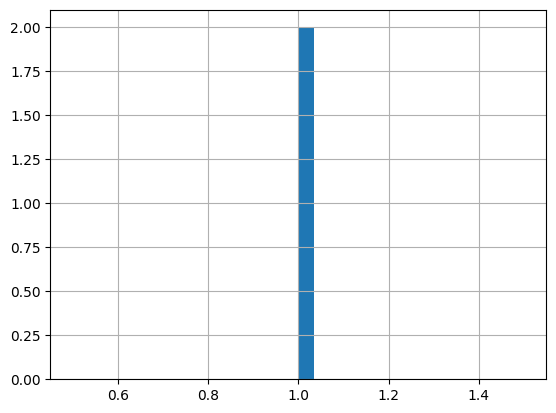

In [190]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [191]:
max_seq_len = 75

In [192]:
train_sec = train_text['sectionName'].tolist()
train_text = train_text['string']
val_sec = val_text['sectionName'].tolist()
val_text = val_text['string']
test_sec = test_text['sectionName'].tolist()
test_text = test_text['string']

In [193]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [194]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_sec = torch.tensor(train_sec)
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_sec = torch.tensor(val_sec)
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_sec = torch.tensor(test_sec)
test_y = torch.tensor(test_labels.tolist())

In [195]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_sec, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_sec, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [37]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [274]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
        self.relu =  nn.ReLU()
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,3)
        self.fc3 = nn.Linear(4,3)
        
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask, sec):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
        
        x = torch.cat((x, sec.float().view(-1, 1)), 1)
        
        x = self.fc3(x)
        
        # apply softmax activation
        x = self.softmax(x)
        return x

In [275]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [276]:
# optimizer from hugging face transformers
from torch.optim import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [277]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.56769972 1.19776228 2.47760745]


In [285]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [279]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, sec, labels = batch
    
    # clear previously calculated gradients 
    model.zero_grad()        
    
    # get model predictions for the current batch
    preds = model(sent_id, mask, sec)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [282]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, sec, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask, sec)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [283]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Evaluating...

Training Loss: 1.099
Validation Loss: 1.107

 Epoch 2 / 20
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Evaluating...

Training Loss: 1.099
Validation Loss: 1.098

 Epoch 3 / 20
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Evaluating...

Training Loss: 1.097
Validation Loss: 1.110

 Epoch 4 / 20
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Evaluating...

Training Loss: 1.098
Validation Loss: 1.094

 Epoch 5 / 20
  Batch    50  of    258.
  Batch   100  of    258.
  Batch   150  of    258.
  Batch   200  of    258.
  Batch   250  of    258.

Evaluating...

Training Loss: 1.09

In [284]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [286]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device), test_sec.to(device))
  preds = preds.detach().cpu().numpy()

In [287]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       498
           1       0.42      0.70      0.52       302
           2       0.17      0.56      0.26       130

    accuracy                           0.31       930
   macro avg       0.20      0.42      0.26       930
weighted avg       0.16      0.31      0.21       930



/environment/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/environment/miniconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [288]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,1,2
row_0,,
0,240,258
1,212,90
2,57,73
